# Librerias y funciones

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, laplace_transform, Heaviside, exp
from scipy.signal import firwin, lfilter
from scipy.integrate import cumulative_trapezoid

In [ ]:
def normalizar_datos(accX, accY, accZ, recorteInf, recorteSup):
  accX = accX[recorteInf:recorteSup]
  accY = accY[recorteInf:recorteSup]
  accZ = accZ[recorteInf:recorteSup]

  end = step * len(accX)
  tiempo = np.arange(0, end, step)

  prom_accX = sum(accX)/len(accX)
  prom_accY = sum(accY)/len(accY)
  prom_accZ = sum(accZ)/len(accZ)

  for i in range(len(accX)):
    accX[i] = accX[i] - prom_accX
    accY[i] = accY[i] - prom_accY
    accZ[i] = accZ[i] - prom_accZ

  r = [accX, accY, accZ]
  return r

In [ ]:
def integral_vel_pos(accX, accY, accZ, tiempo):

  v0 = 0
  p0 = 0

  velX = cumulative_trapezoid(accX, tiempo, initial=v0)
  posX = cumulative_trapezoid(velX, tiempo, initial=p0)

  velY = cumulative_trapezoid(accY, tiempo, initial=v0)
  posY = cumulative_trapezoid(velY, tiempo, initial=p0)

  velZ = cumulative_trapezoid(accZ, tiempo, initial=v0)
  posZ = cumulative_trapezoid(velZ, tiempo, initial=p0)

  r = [velX, velY, velZ, posX, posY, posZ]
  return r

In [ ]:
def filtro_pasabajos(data, f_corte, orden, fs):
  pasabajos = firwin(orden, f_corte, fs=fs) # Ventana Hamming por defecto
  data_f = lfilter(pasabajos, 1.0, data)
  return data_f

# Datos Karts

## Manejo de datos

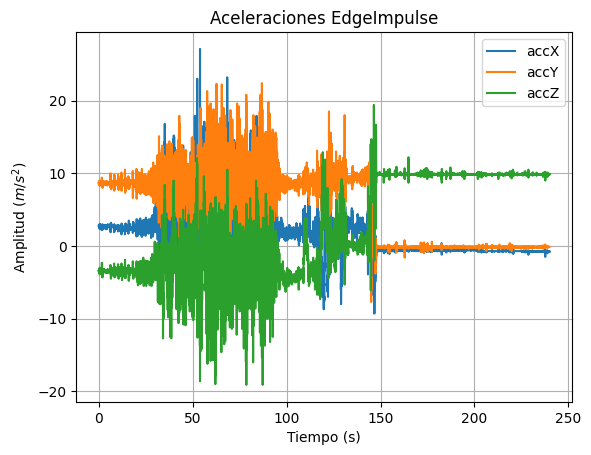

In [ ]:
with open('DatosEI.json', 'r') as archivo:
    datos = json.load(archivo)

valores = datos['payload']['values']

accX = []
accY = []
accZ = []

for i in valores:
  accX.append(i[0])
  accY.append(i[1])
  accZ.append(i[2])

step = 0.016
end = step * len(accX)
tiempo = np.arange(0, end, step)

#----------------------------------------------------------------------

plt.plot(tiempo, accX, label="accX")
plt.plot(tiempo, accY, label="accY")
plt.plot(tiempo, accZ, label="accZ")
plt.title("Aceleraciones EdgeImpulse")
plt.xlabel("Tiempo (s)");
plt.ylabel("Amplitud ($m/s^2$)");
plt.legend()
plt.grid()
plt.show()

## Normalización respecto al cero (Offset)

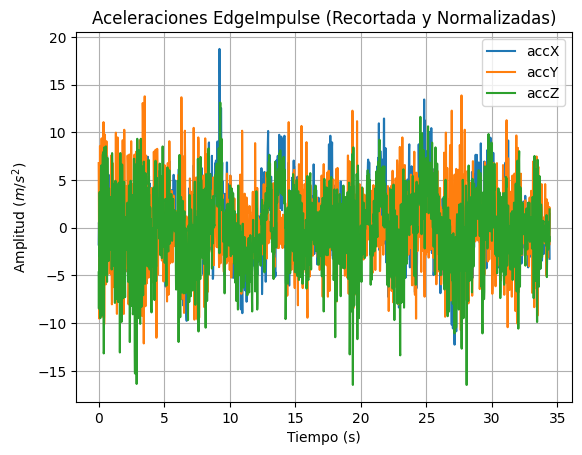

In [ ]:
num = 1900
r1 = normalizar_datos(accX, accY, accZ, num*2-100, num*3+151)

accX, accY, accZ = r1[0], r1[1], r1[2]
tiempo = np.arange(0, step * len(accX), step)

#----------------------------------------------------------------------

plt.plot(tiempo, accX, label="accX")
plt.plot(tiempo, accY, label="accY")
plt.plot(tiempo, accZ, label="accZ")
plt.title("Aceleraciones EdgeImpulse (Recortada y Normalizadas)");
plt.xlabel("Tiempo (s)");
plt.ylabel("Amplitud ($m/s^2$)");
plt.legend()
plt.grid()
plt.show()


## Transformada de Fourier

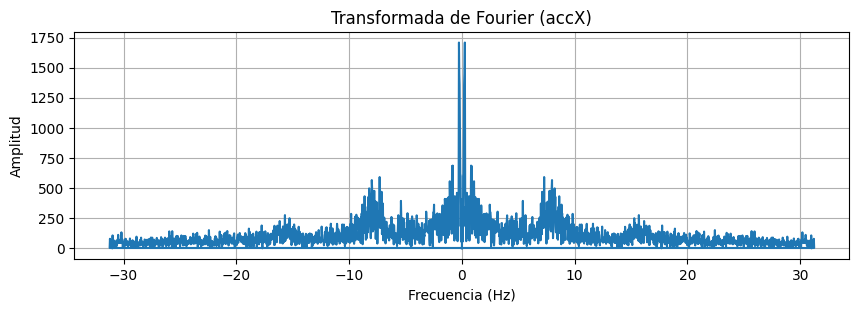

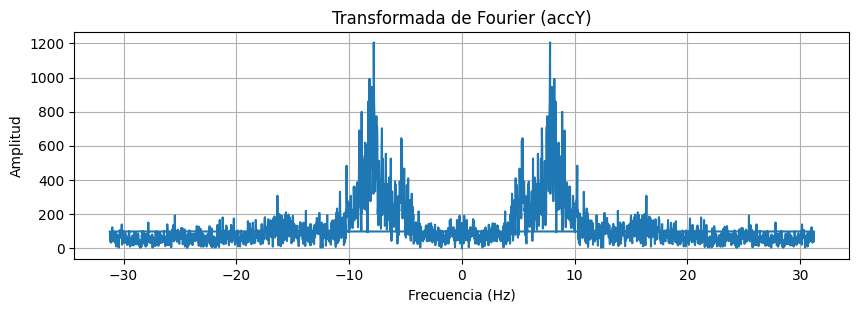

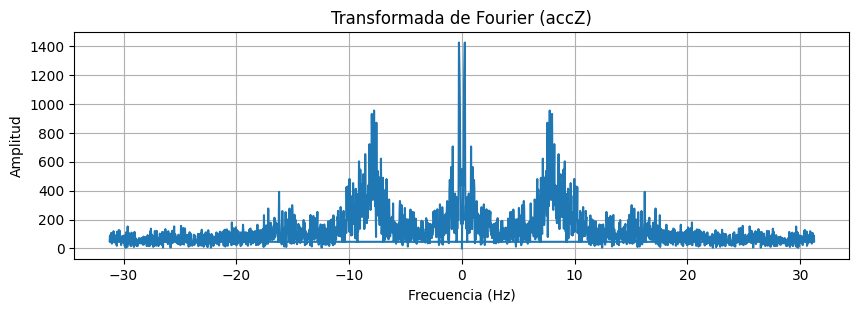

In [ ]:
fs = 1/step
frequencias = np.fft.fftfreq(len(tiempo), d=1/fs)

fft_accX = np.fft.fft(accX)
magnitud_accX = np.abs(fft_accX)
fase_accX = np.angle(fft_accX)

fft_accY = np.fft.fft(accY)
magnitud_accY = np.abs(fft_accY)
fase_accY = np.angle(fft_accY)

fft_accZ = np.fft.fft(accZ)
magnitud_accZ = np.abs(fft_accZ)
fase_accZ = np.angle(fft_accZ)

#----------------------------------------------------------------------

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(frequencias, magnitud_accX)
plt.title("Transformada de Fourier (accX)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.plot(frequencias, magnitud_accY)
plt.title("Transformada de Fourier (accY)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.plot(frequencias, magnitud_accZ)
plt.title("Transformada de Fourier (accZ)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

## Filtrado FIR

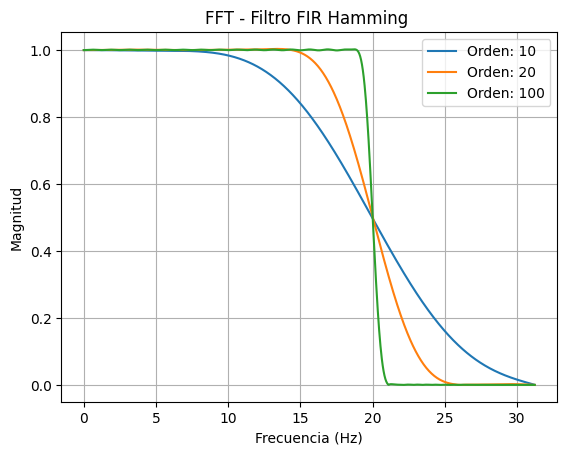

In [ ]:
f_corte = 20
fs = 1/step

orden = 10
pasabajos = firwin(orden, f_corte, fs=fs)

fft_filtro = np.fft.fft(pasabajos, n=2048)
magnitud = np.abs(fft_filtro)
frecuencias = np.fft.fftfreq(len(fft_filtro), d=1/fs)

#----------------------------------------------------------------------

orden = 20
pasabajos = firwin(orden, f_corte, fs=fs)

fft_filtro2 = np.fft.fft(pasabajos, n=2048)
magnitud2 = np.abs(fft_filtro2)
frecuencias2 = np.fft.fftfreq(len(fft_filtro2), d=1/fs)

#----------------------------------------------------------------------

orden = 100
pasabajos = firwin(orden, f_corte, fs=fs)

fft_filtro3 = np.fft.fft(pasabajos, n=2048)
magnitud3 = np.abs(fft_filtro3)
frecuencias3 = np.fft.fftfreq(len(fft_filtro3), d=1/fs)

#----------------------------------------------------------------------

plt.plot(frecuencias[:len(frecuencias)//2], magnitud[:len(frecuencias)//2], label="Orden: 10")
plt.plot(frecuencias2[:len(frecuencias2)//2], magnitud2[:len(frecuencias2)//2], label="Orden: 20")
plt.plot(frecuencias3[:len(frecuencias3)//2], magnitud3[:len(frecuencias3)//2], label="Orden: 100")
plt.title("FFT - Filtro FIR Hamming ")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.legend()
plt.grid()
plt.show()

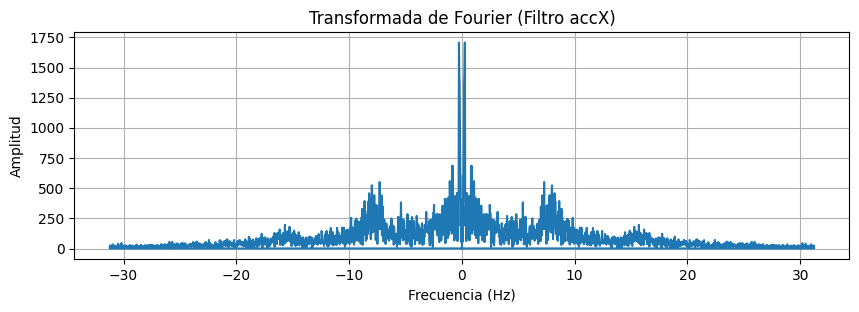

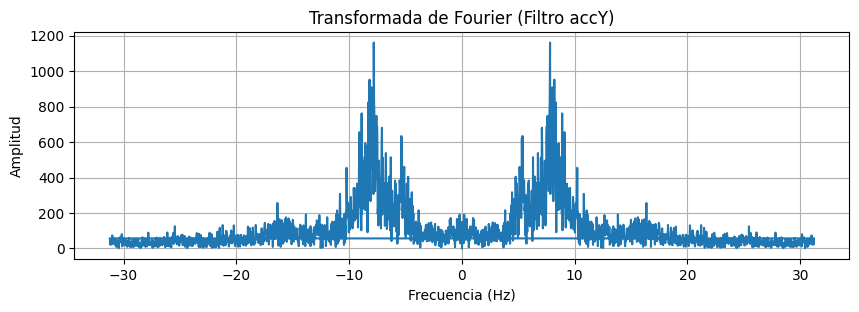

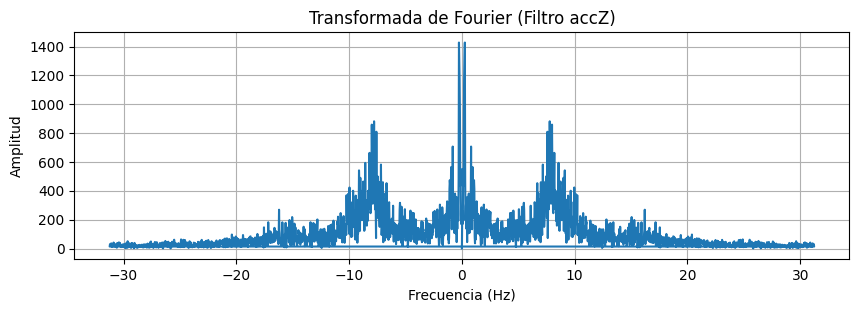

In [ ]:
frequencias = np.fft.fftfreq(len(tiempo), d=1/fs)

accX_f = filtro_pasabajos(accX, 20, 5, fs)
fft_accX_f = np.fft.fft(accX_f)
magnitud_accX_f = np.abs(fft_accX_f)

accY_f = filtro_pasabajos(accY, 25, 5, fs)
fft_accY_f = np.fft.fft(accY_f)
magnitud_accY_f = np.abs(fft_accY_f)

accZ_f = filtro_pasabajos(accZ, 20, 5, fs)
fft_accZ_f = np.fft.fft(accZ_f)
magnitud_accZ_f = np.abs(fft_accZ_f)

#----------------------------------------------------------------------

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(frequencias, magnitud_accX_f)
plt.title("Transformada de Fourier (Filtro accX)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.plot(frequencias, magnitud_accY_f)
plt.title("Transformada de Fourier (Filtro accY)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.plot(frequencias, magnitud_accZ_f)
plt.title("Transformada de Fourier (Filtro accZ)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

## Integración (Vel y Pos)

In [ ]:
r1 = integral_vel_pos(accX, accY, accZ, tiempo)
velX, velY, velZ, posX, posY, posZ = r1[0], r1[1], r1[2], r1[3], r1[4], r1[5]

r2 = integral_vel_pos(accX_f, accY_f, accZ_f, tiempo)
velX_f, velY_f, velZ_f, posX_f, posY_f, posZ_f = r2[0], r2[1], r2[2], r2[3], r2[4], r2[5]

## Aproximación de la pista

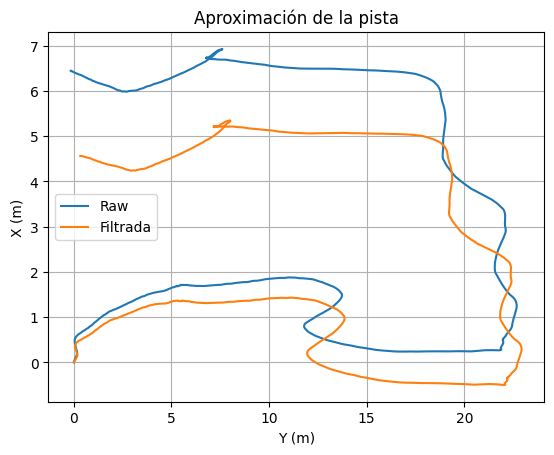

In [ ]:
for i in range(len(posX)):
  posX[i] = posX[i] * -1
  posY[i] = posY[i] * -1

for i in range(len(posX_f)):
  posX_f[i] = posX_f[i] * -1
  posY_f[i] = posY_f[i] * -1

plt.plot(posX, posY, label="Raw")
plt.plot(posX_f, posY_f, label="Filtrada")
plt.title("Aproximación de la pista")
plt.xlabel("Y (m)");
plt.ylabel("X (m)");
plt.legend();
plt.grid()
plt.show()

# Datos Rotonda

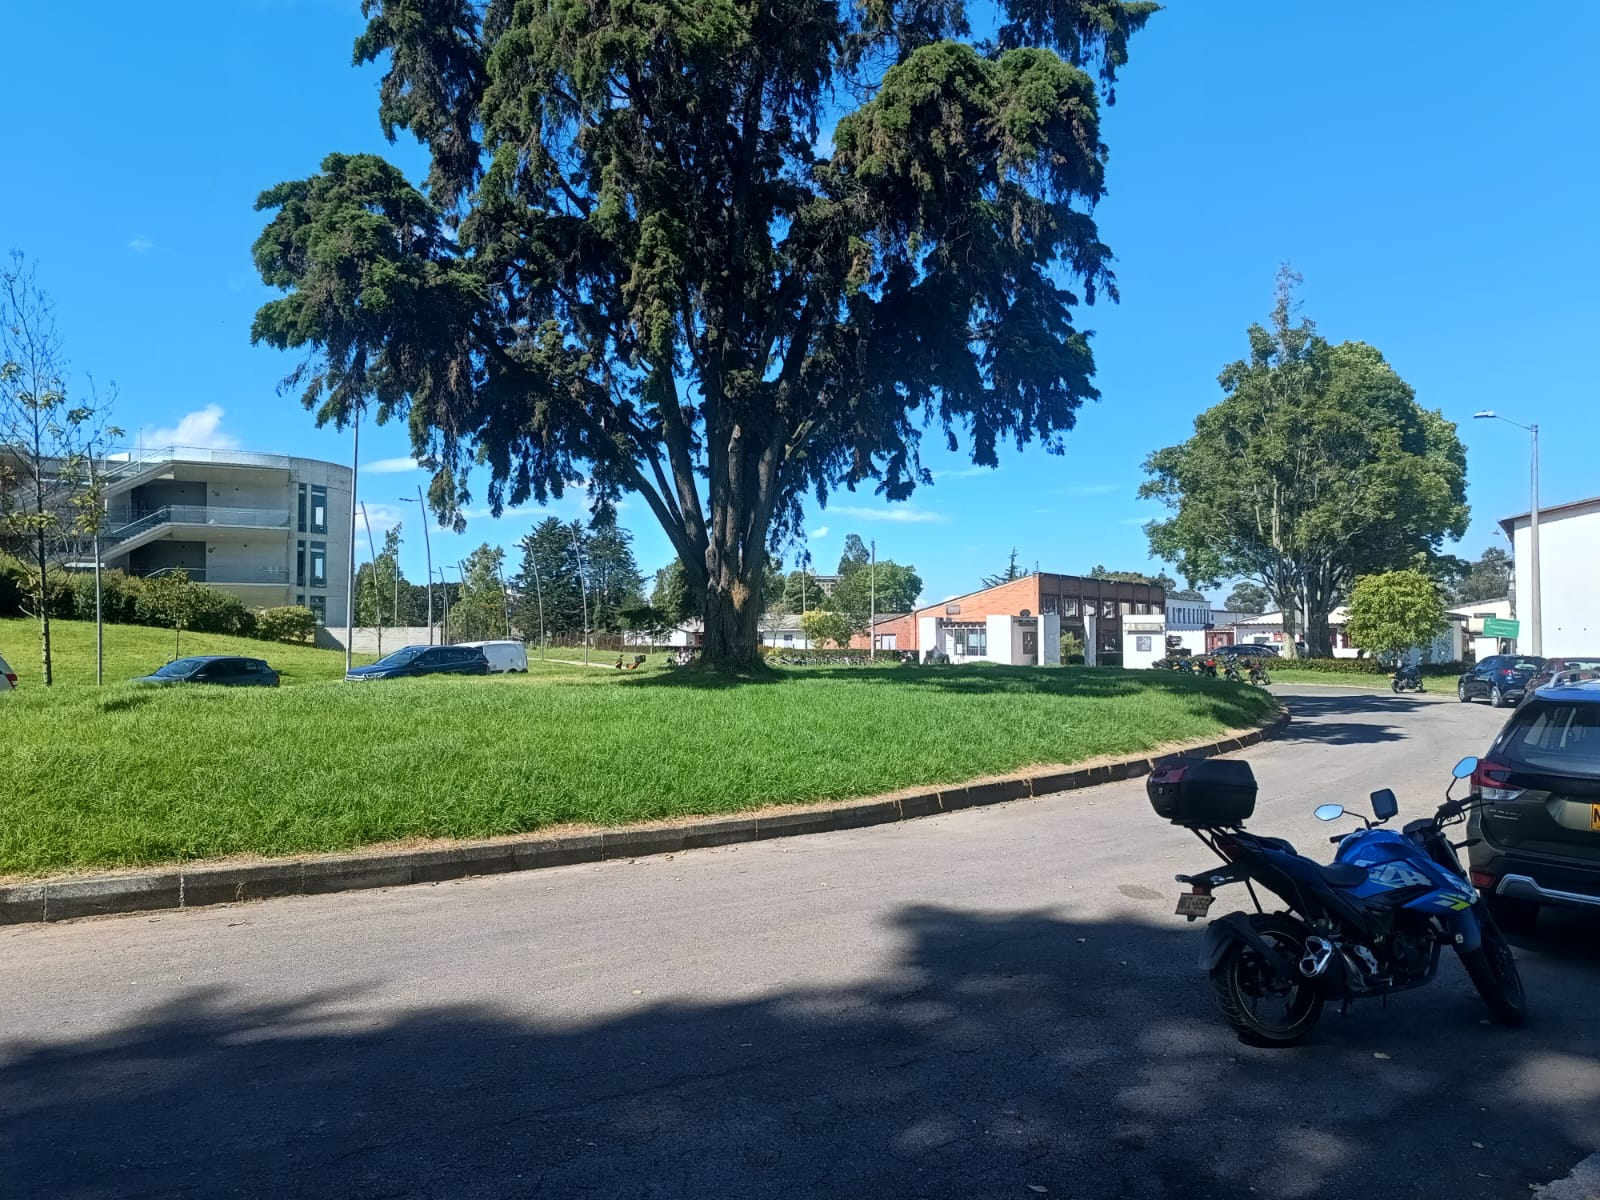

## Manejo de datos

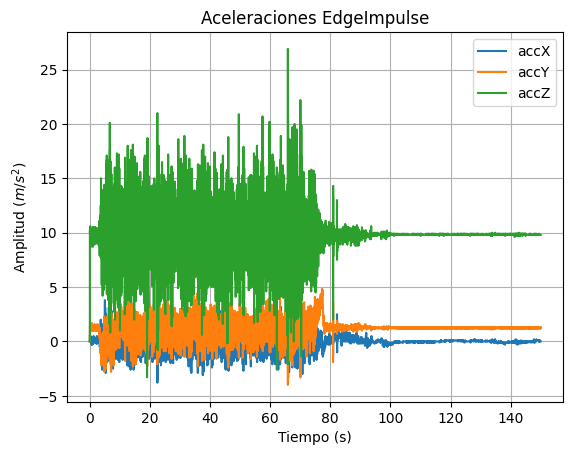

In [ ]:
with open('DatosEI_C.json', 'r') as archivo:
    datos = json.load(archivo)

valores = datos['payload']['values']

accX = []
accY = []
accZ = []

for i in valores:
  accX.append(i[0])
  accY.append(i[1])
  accZ.append(i[2])

step = 0.016
end = step * len(accX)
tiempo = np.arange(0, end, step)

#----------------------------------------------------------------------

plt.plot(tiempo, accX, label="accX")
plt.plot(tiempo, accY, label="accY")
plt.plot(tiempo, accZ, label="accZ")
plt.title("Aceleraciones EdgeImpulse")
plt.xlabel("Tiempo (s)");
plt.ylabel("Amplitud ($m/s^2$)");
plt.legend()
plt.grid()
plt.show()

## Normalización respecto al cero (Offset)

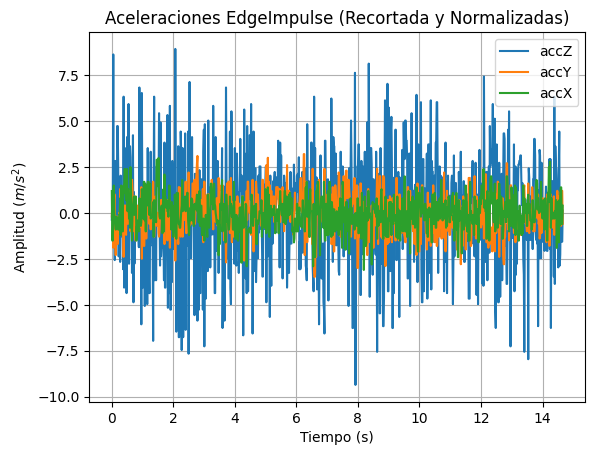

In [ ]:
num = 1667
r1 = normalizar_datos(accX, accY, accZ, num*1+170, num*2-580)

accX, accY, accZ = r1[0], r1[1], r1[2]
tiempo = np.arange(0, step * len(accX), step)

#----------------------------------------------------------------------

plt.plot(tiempo, accZ, label="accZ")
plt.plot(tiempo, accY, label="accY")
plt.plot(tiempo, accX, label="accX")
plt.title("Aceleraciones EdgeImpulse (Recortada y Normalizadas)");
plt.xlabel("Tiempo (s)");
plt.ylabel("Amplitud ($m/s^2$)");
plt.legend()
plt.grid()
plt.show()

## Transformada de Fourier

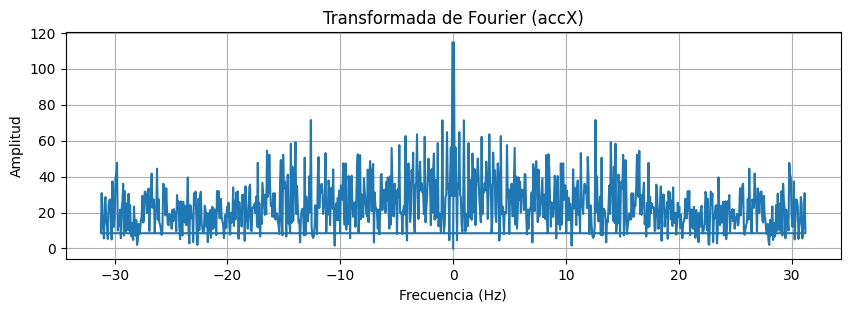

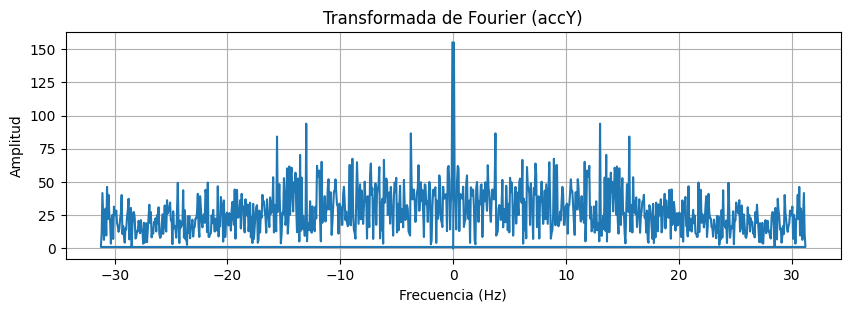

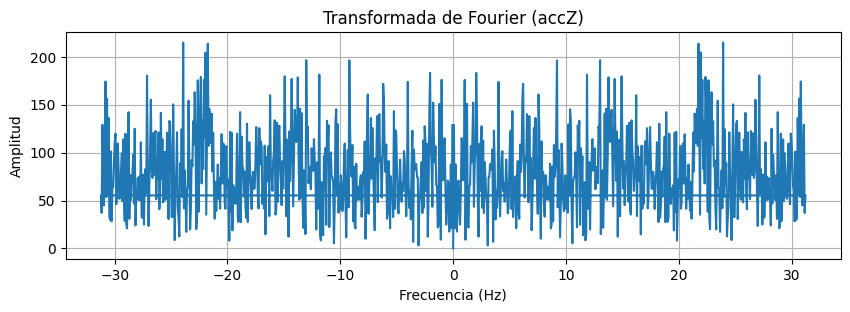

In [ ]:
fs = 1/step
frequencias = np.fft.fftfreq(len(tiempo), d=1/fs)

fft_accX = np.fft.fft(accX)
magnitud_accX = np.abs(fft_accX)
fase_accX = np.angle(fft_accX)

fft_accY = np.fft.fft(accY)
magnitud_accY = np.abs(fft_accY)
fase_accY = np.angle(fft_accY)

fft_accZ = np.fft.fft(accZ)
magnitud_accZ = np.abs(fft_accZ)
fase_accZ = np.angle(fft_accZ)

#----------------------------------------------------------------------

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(frequencias, magnitud_accX)
plt.title("Transformada de Fourier (accX)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.plot(frequencias, magnitud_accY)
plt.title("Transformada de Fourier (accY)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.plot(frequencias, magnitud_accZ)
plt.title("Transformada de Fourier (accZ)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

## Filtrado FIR

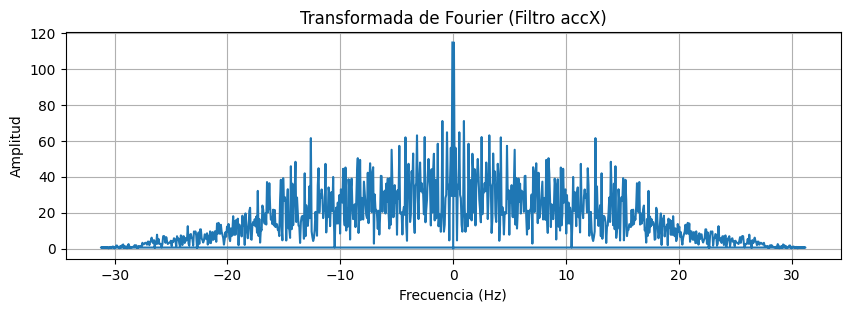

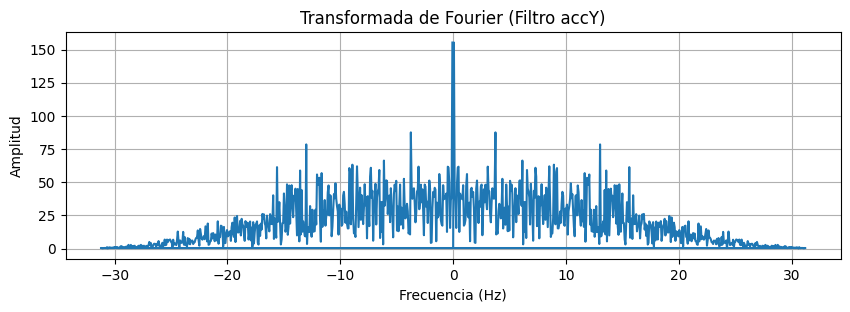

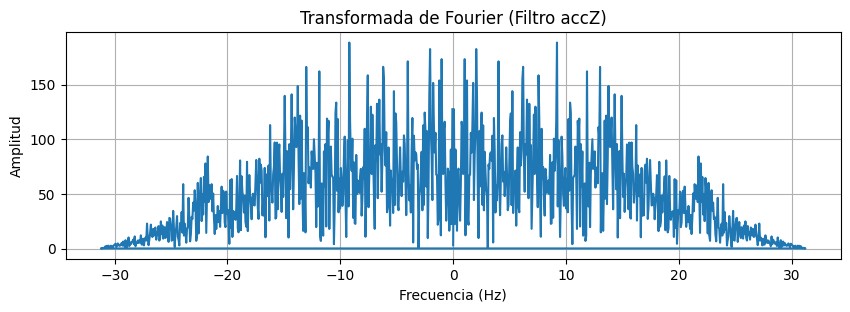

In [ ]:
frequencias = np.fft.fftfreq(len(tiempo), d=1/fs)

accX_f = filtro_pasabajos(accX, 20, 8, fs)
fft_accX_f = np.fft.fft(accX_f)
magnitud_accX_f = np.abs(fft_accX_f)

accY_f = filtro_pasabajos(accY, 20, 8, fs)
fft_accY_f = np.fft.fft(accY_f)
magnitud_accY_f = np.abs(fft_accY_f)

accZ_f = filtro_pasabajos(accZ, 20, 8, fs)
fft_accZ_f = np.fft.fft(accZ_f)
magnitud_accZ_f = np.abs(fft_accZ_f)

#----------------------------------------------------------------------

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.plot(frequencias, magnitud_accX_f)
plt.title("Transformada de Fourier (Filtro accX)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.plot(frequencias, magnitud_accY_f)
plt.title("Transformada de Fourier (Filtro accY)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.plot(frequencias, magnitud_accZ_f)
plt.title("Transformada de Fourier (Filtro accZ)");
plt.xlabel("Frecuencia (Hz)");
plt.ylabel("Amplitud");
plt.grid()
plt.show()

## Integración (Vel y Pos)

In [ ]:
r1 = integral_vel_pos(accX, accY, accZ, tiempo)
velX, velY, velZ, posX, posY, posZ = r1[0], r1[1], r1[2], r1[3], r1[4], r1[5]

r2 = integral_vel_pos(accX_f, accY_f, accZ_f, tiempo)
velX_f, velY_f, velZ_f, posX_f, posY_f, posZ_f = r2[0], r2[1], r2[2], r2[3], r2[4], r2[5]

## Aproximación de la pista

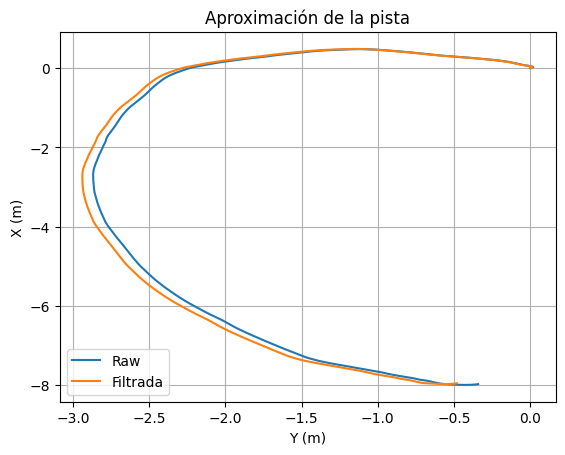

In [ ]:
for i in range(len(posX)):
  posX[i] = posX[i] * -1
  posY[i] = posY[i] * -1

for i in range(len(posX_f)):
  posX_f[i] = posX_f[i] * -1
  posY_f[i] = posY_f[i] * -1

plt.plot(posX, posY, label="Raw")
plt.plot(posX_f, posY_f, label="Filtrada")
plt.title("Aproximación de la pista")
plt.xlabel("Y (m)");
plt.ylabel("X (m)");
plt.legend();
plt.grid()
plt.show()

## Aceleración tangencia en trayectoria


$\vec{a}_t = \frac{\vec{v} \cdot \vec{a}}{|\vec{v}|^2} \cdot \vec{v}$


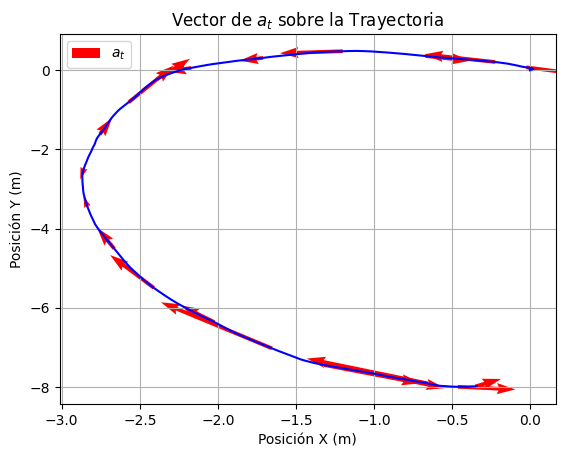

In [ ]:
v = np.sqrt(velX**2 + velY**2)

v_cuadrado = np.where(v > 0, v**2, 1e-10)

producto_punto = velX * accX + velY * accY

at_x = (producto_punto / v_cuadrado) * velX
at_y = (producto_punto / v_cuadrado) * velY

plt.plot(posX, posY, color="blue")

step = max(1, len(tiempo) // 20)
plt.quiver(
    posX[::step], posY[::step], at_x[::step], at_y[::step],
    angles="xy", scale_units="xy", scale=1.5, color="red", label="$a_t$")

plt.xlabel("Posición X (m)")
plt.ylabel("Posición Y (m)")
plt.title("Vector de $a_t$ sobre la Trayectoria")
plt.grid()
plt.legend()
plt.show()